# Burundi country profile

In [1]:
import os, sys, glob, json
os.chdir('../gscd/notebook/')
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [2]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('../data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32735'
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/BI_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1982	 | BI1982A1 | 15	| nan	| 0	| nan	| 0	|
| 1991	 | BI1991A1 | 16	| nan	| 0	| nan	| 0	|
| 1998	 | BI1998A1 | 17	| nan	| 0	| nan	| 0	|
| 2004	 | BI2004A1 | 17	| BI2004A2	| 129	| nan	| 0	|
| 2017	 | BI2017A1 | 18	| nan	| 0	| nan	| 0	|
----------------------------------------------- #


In [3]:
#FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
auth = ('cxuan', 'cx941207')
#read in username and password
# exec(open('/Users/wanders7/Documents/Code/Logins/FDW.py').read())
parameters = {
    'format': 'json',
    'country': 'Burundi',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionfacts/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

In [4]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting
# a.1) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# a.2) Early in the record the catch-all crop production system is 'all' rather than none. Make these to none-type
df.loc[df['crop_production_system'] == 'all', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #
#Drop the hundreds of blank (nan) rows that are duplicates of rows that do have data
df = df[np.isfinite(df.value)]
df = df[df['admin_2'].isna()]


# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# # FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([BI_Admin1_1982,BI_Admin1_1991,BI_Admin1_1998], axis=0)
PlotAdminShapes(shape_used, label=True)
# # ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 2,844
Removed 172 "Missing Value" points
1,770/1,796 "Quantity Produced" points are retained.
525/525 "Area Planted" points are retained.
377/523 "Yield" points are retained.
Current data points: 2,672

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1996 - 2015
6 grain types are found: Maize (Corn), Millet (Finger), Rice (Paddy), Rice, not husked, Sorghum, Wheat Grain
3 seasons are found: Season A (09-01), Season C (06-01), Season B (02-01)
1 crop production system are found: none
Data sources include:
[1] Institut de Statistiques et d’Etudes Economiques du Burundi (ISTEEBU), Burundi --- Annuaire Statistique, Burundi
[2] Institut de Statistiques et d’Etudes Economiques du Burundi (ISTEEBU), Burundi --- ENAB, Burundi
[3] Ministere de l'Agriculture et de l'Elevage/DSIA --- ENAB, Burundi
Administrative-1 fnids: 31
Administrative-2 fnids: 0
0 reporting 

## Burundi
Burundi crop seasonal calendar

![FEWS NET](https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-burundi%20%281%29.png?itok=v2zPE4Fr)

![USDA](https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/eafrica_by_calendar.png)


- comparison of boundaries
![image](./figures/BI_admin_shapes.png)

- In Burundi, basd on the FEWS NET data, there were four times of changes in administrative units: 1991,1998,2004,2017

| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1982	 | BI1982A1 | 15	| nan	| 0	|
| 1991	 | BI1991A1 | 16	| nan	| 0	|
| 1998	 | BI1998A1 | 17	| nan	| 0	|
| 2004	 | BI2004A1 | 17	| BI2004A2	| 129	|
| 2017	 | BI2017A1 | 18	| nan	| 0	|

- Here, we use **`BI1998A1`** to represent all admin-level 1 crop data because although there are 2004 and 2017 file, they don't appear to be used (e.g. no corresponding FNIDs)
- The data is available at admin level 1
- At admin-level 1,five crops have three seasons`Season A`,`Season B`,and `Season C`;Rice, not husked only has two seasons `Season A`and`Season B`

In [5]:
sorted(list(df_origin['season_year'].unique()))

['Season A 1996',
 'Season A 1997',
 'Season A 1998',
 'Season A 2000',
 'Season A 2001',
 'Season A 2002',
 'Season A 2003',
 'Season A 2005',
 'Season A 2006',
 'Season A 2007',
 'Season A 2008',
 'Season A 2009',
 'Season A 2010',
 'Season A 2011',
 'Season A 2012',
 'Season A 2013',
 'Season A 2014',
 'Season A 2015',
 'Season B 1996',
 'Season B 1997',
 'Season B 1998',
 'Season B 2000',
 'Season B 2001',
 'Season B 2002',
 'Season B 2003',
 'Season B 2005',
 'Season B 2006',
 'Season B 2007',
 'Season B 2008',
 'Season B 2009',
 'Season B 2010',
 'Season B 2011',
 'Season B 2012',
 'Season B 2013',
 'Season B 2014',
 'Season C 1996',
 'Season C 1997',
 'Season C 1998',
 'Season C 2000',
 'Season C 2001',
 'Season C 2002',
 'Season C 2003',
 'Season C 2005',
 'Season C 2006',
 'Season C 2007',
 'Season C 2008',
 'Season C 2009',
 'Season C 2010',
 'Season C 2011',
 'Season C 2012',
 'Season C 2013',
 'Season C 2014']

In [6]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = BI_Admin1_1998.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #
# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()

In [7]:
# Link admin boundaries ------------------------- #
link_1982, over_1982 = FDW_PD_CreateAdminLink(BI_Admin1_1982,BI_Admin1_1998, 'ADMIN1', 'ADMIN1', prod, epsg)
link_1991, over_1991 = FDW_PD_CreateAdminLink(BI_Admin1_1991,BI_Admin1_1998, 'ADMIN1', 'ADMIN1', prod, epsg)

# Crop specific ratios
link_ratio_1982 = FDW_PD_RatioAdminLink(link_1982, prod, over_1982, mdx_pss)
link_ratio_1991 = FDW_PD_RatioAdminLink(link_1991, prod, over_1991, mdx_pss)

# Merge link_ratio
assert link_ratio_1982.keys() == link_ratio_1991.keys()
link_merged = [link_ratio_1991]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)

# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

CBR is considered for 'BI1982A102' as no record found in: ['BI1998A102']
CBR is considered for 'BI1991A102' as no record found in: ['BI1998A102']


In [8]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack_gscd = stack[names]
stack_gscd['gscd_code'] = 'calibrated'
# ----------------------------------------------- #
# Reported FDW data ----------------------------- #
stack_fdw = df[names]
stack_fdw['indicator'] = stack_fdw['indicator'].replace({'Area Harvested':'area','Quantity Produced':'production','Yield':'yield'})
stack_fdw['gscd_code'] = 'reported'
# ----------------------------------------------- #
# Final Processing ------------------------------ #
stack = pd.concat([stack_fdw,stack_gscd], axis=0).reset_index(drop=True)
# No concerns found for grain types
stack['product'] = stack['product'].replace(product_category)
# Calibration of Planting and Harvest year and season
cs = {
     'Season A': {'planting_month': {'09-01': '09-01'}, 'harvest_month': {'01-01': '01-01'}},
     'Season B': {'planting_month': {'02-01': '02-01'}, 'harvest_month': {'05-01': '05-01'}},
     'Season C': {'planting_month': {'06-01': '06-01'}, 'harvest_month': {'08-01': '08-01'}}
}
cy = {}
stack, df, link_ratio = FDW_PD_CaliSeasonYear(stack, df, link_ratio, cs, cy)
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# # ----------------------------------------------- #

# Save data
save_hdf('../data/crop/adm_crop_production_BI.hdf', stack)
save_hdf('../data/crop/adm_crop_production_BI_raw.hdf', df)
save_npz('../data/crop/adm_crop_production_BI_ratio.npz', link_ratio)

../data/crop/adm_crop_production_BI.hdf is saved.
../data/crop/adm_crop_production_BI_raw.hdf is saved.
../data/crop/adm_crop_production_BI_ratio.npz is saved.


In [9]:
stack_gscd

fnid  country country_code  admin_1 admin_2     name  \
0     BI1998A101  Burundi           BI  Bubanza    None  Bubanza   
1     BI1998A101  Burundi           BI  Bubanza    None  Bubanza   
2     BI1998A101  Burundi           BI  Bubanza    None  Bubanza   
3     BI1998A101  Burundi           BI  Bubanza    None  Bubanza   
4     BI1998A101  Burundi           BI  Bubanza    None  Bubanza   
...          ...      ...          ...      ...     ...      ...   
2692  BI1998A117  Burundi           BI   Ruyigi    None   Ruyigi   
2693  BI1998A117  Burundi           BI   Ruyigi    None   Ruyigi   
2694  BI1998A117  Burundi           BI   Ruyigi    None   Ruyigi   
2695  BI1998A117  Burundi           BI   Ruyigi    None   Ruyigi   
2696  BI1998A117  Burundi           BI   Ruyigi    None   Ruyigi   

              product season_name  planting_year planting_month  harvest_year  \
0        Maize (Corn)    Season A           2012          09-01          2013   
1        Maize (Corn)    Season A           2012          09-01          2013   
2        Maize (Corn)    Season A           2012          09-01          2013   
3        Maize (Corn)    Season A           2013          09-01          2014   
4        Maize (Corn)    Season A           2013          09-01          2014   
...               ...         ...            ...            ...           ...   
2692  Millet (Finger)    Season B           2008          02-01          2008   
2693  Millet (Finger)    Season B           2009          02-01          2009   
2694  Millet (Finger)    Season B           2010          02-01          2010   
2695  Millet (Finger)    Season B           2011          02-01          2011   
2696     Rice (Paddy)    Season B           2001          02-01          2001   

     harvest_month crop_production_system   indicator       value   gscd_code  
0            01-01                   none        area  5385.00000  calibrated  
1            01-01                   none  production  4757.00000  calibrated  
2            01-01                   none       yield     0.88338  calibrated  
3            01-01                   none        area  2270.00000  calibrated  
4            01-01                   none  production  3282.00000  calibrated  
...            ...                    ...         ...         ...         ...  
2692         05-01                   none  production  1516.00000  calibrated  
2693         05-01                   none  production  1546.00000  calibrated  
2694         05-01                   none  production  1546.00000  calibrated  
2695         05-01                   none  production  1546.00000  calibrated  
2696         05-01                   none  production   758.00000  calibrated  

[2697 rows x 16 columns]

../figures/BI_bar_natgrainprod_Season A.png is saved.
../figures/BI_bar_natgrainprod_Season B.png is saved.


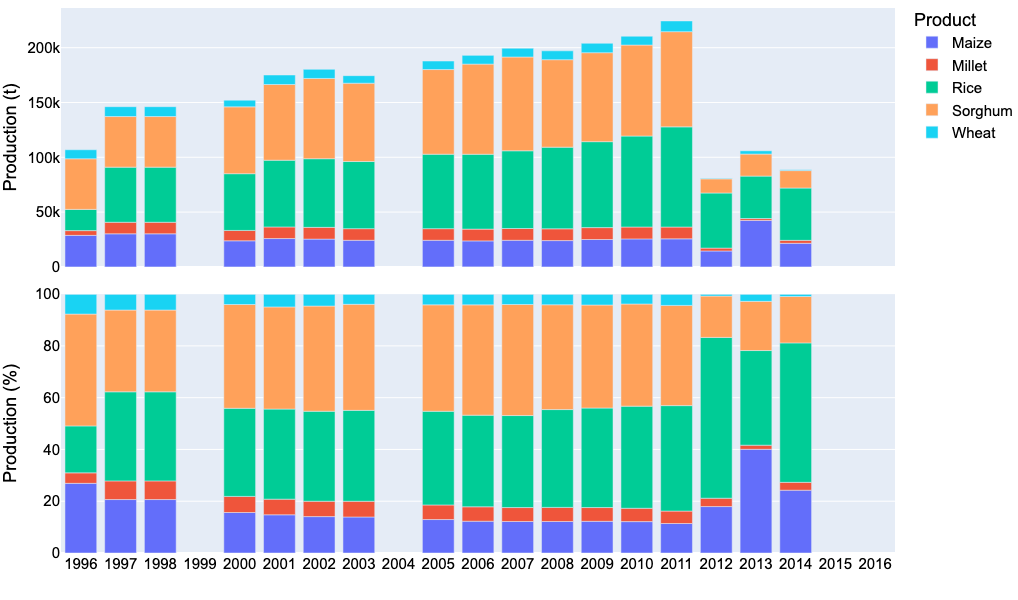

../figures/BI_bar_natgrainprod_Season C.png is saved.


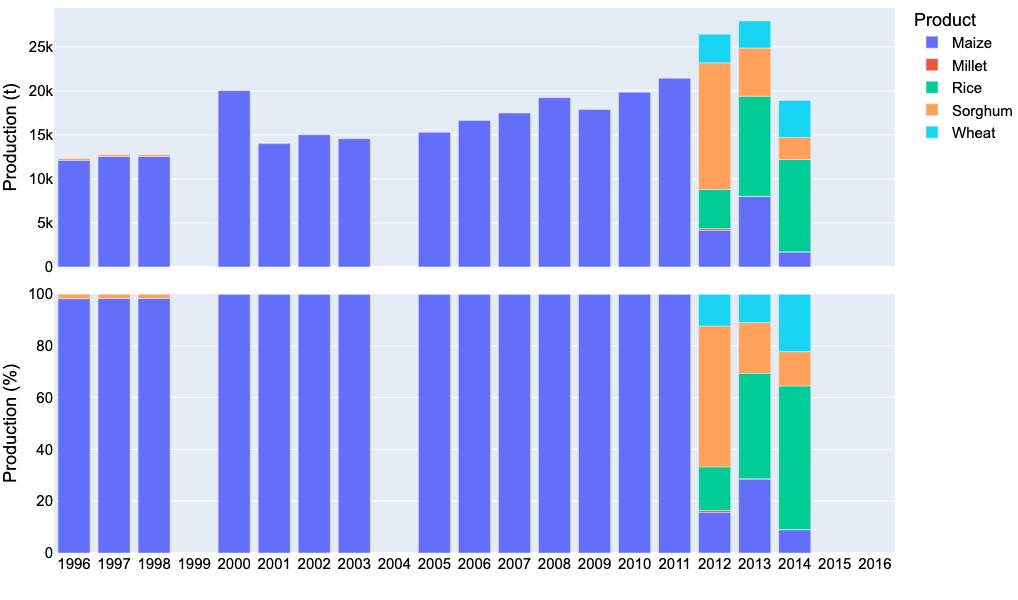

In [10]:
# Bar chart of national grain production
country_iso, country_name = 'BI', 'Burundi'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_order = ['Maize', 'Millet','Rice','Rice, not husked','Sorghum','Wheat']
for season_name in ['Season A','Season B','Season C']:
    footnote = 'National grain production in %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    if len(sub['year'].unique())<5:
        continue
    fig = PlotBarProduction(sub, year, product_order, footnote, fn_save)
    fig.show()


../figures/BI_line_pay_Maize_Season A.png is saved.


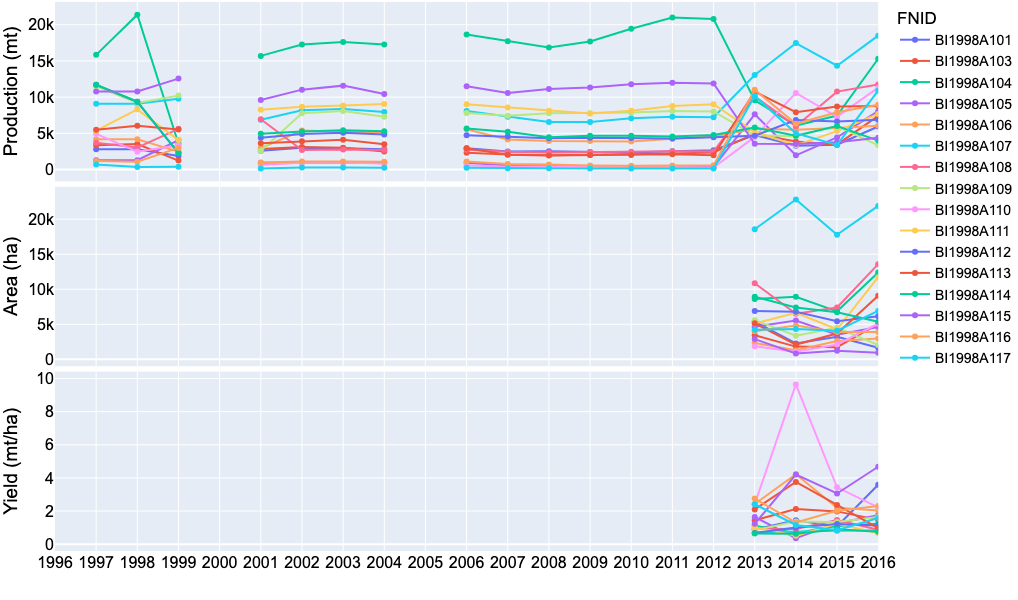

../figures/BI_line_pay_Maize_Season B.png is saved.


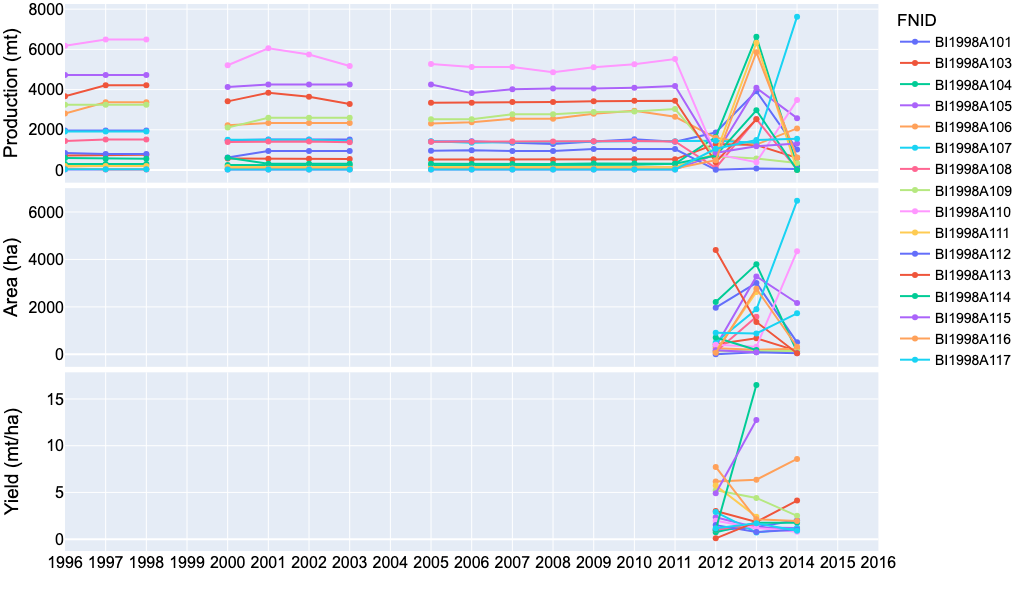

../figures/BI_line_pay_Maize_Season C.png is saved.


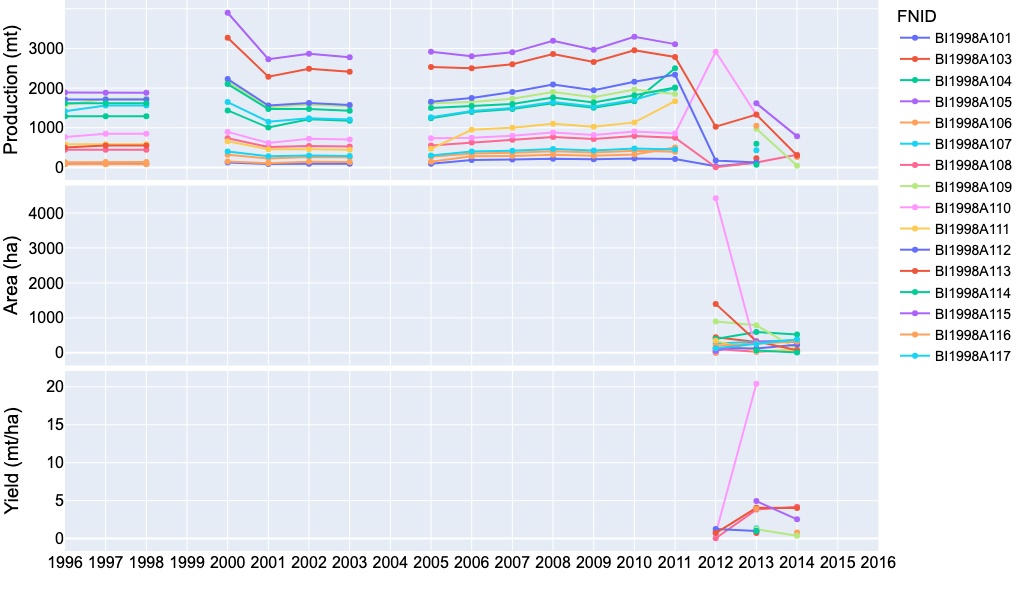

../figures/BI_line_pay_Millet_Season A.png is saved.


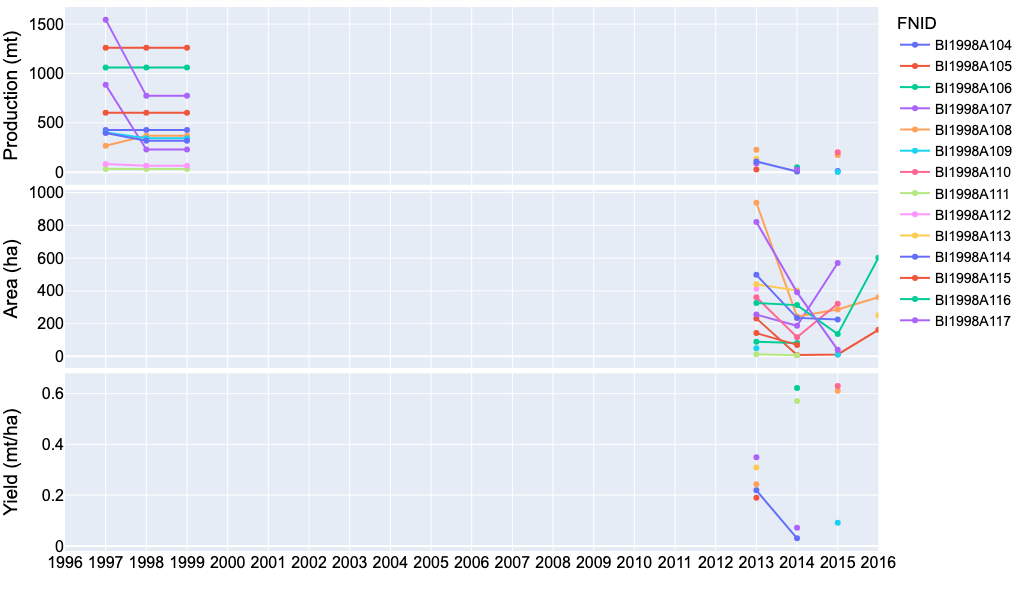

../figures/BI_line_pay_Millet_Season B.png is saved.


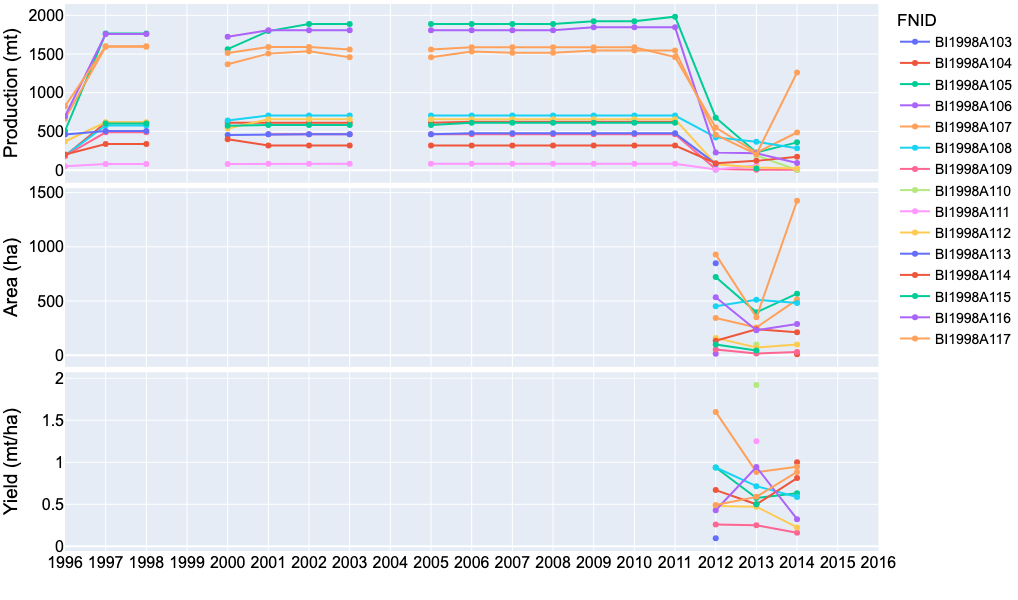

../figures/BI_line_pay_Millet_Season C.png is saved.


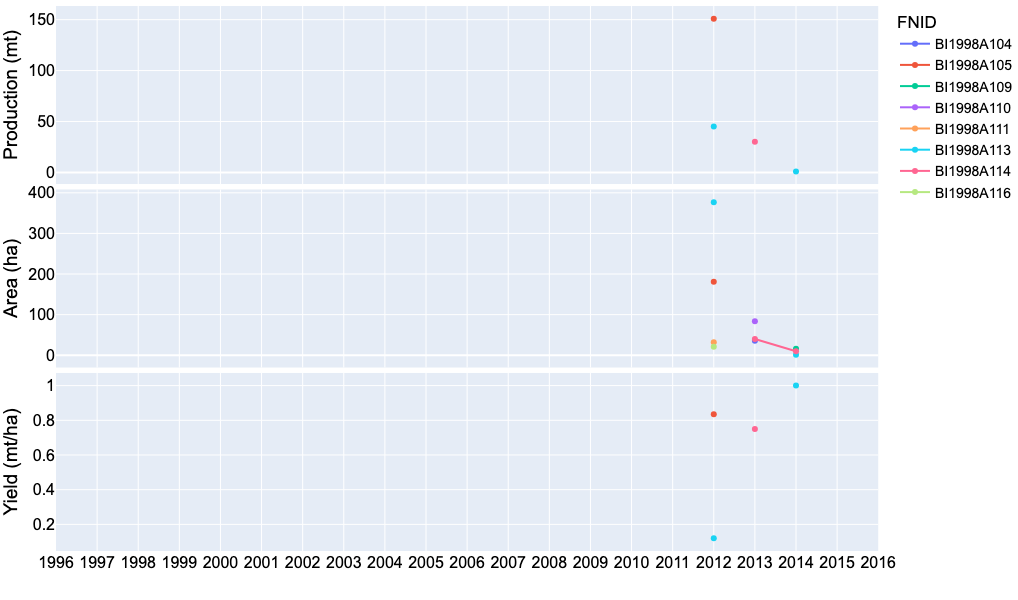

../figures/BI_line_pay_Rice_Season A.png is saved.


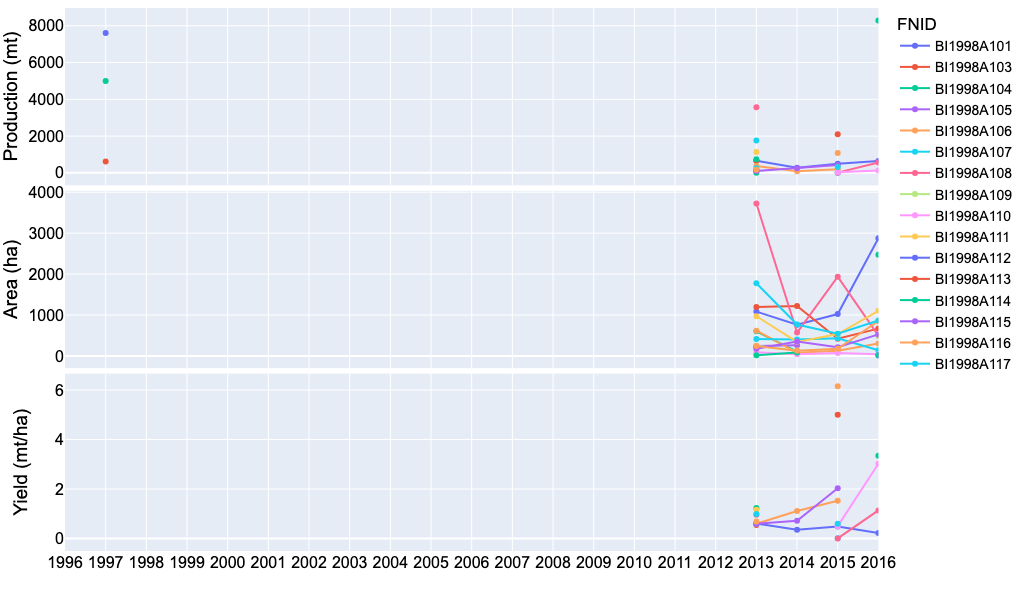

../figures/BI_line_pay_Rice_Season B.png is saved.


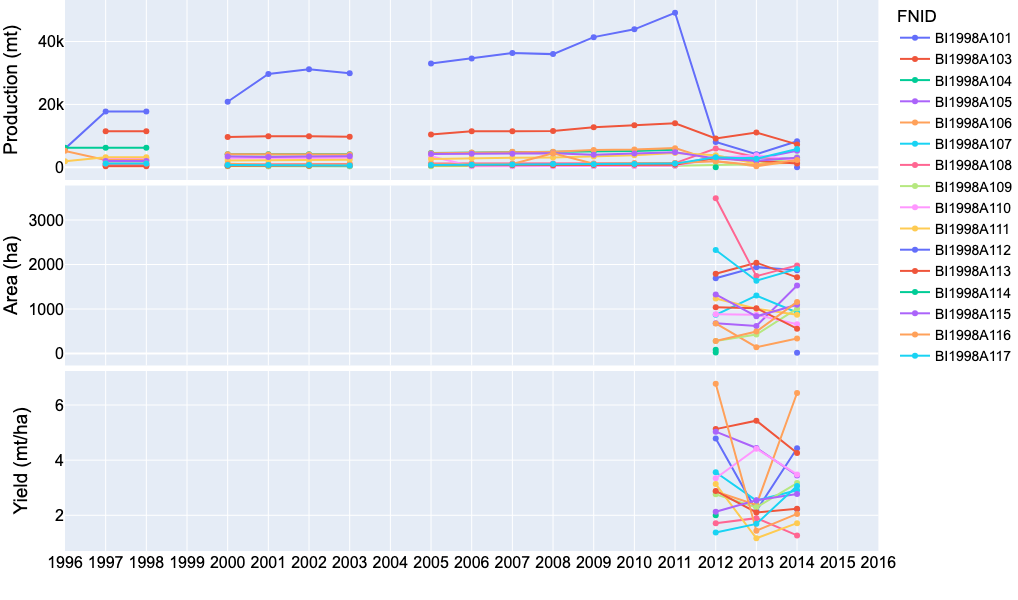

../figures/BI_line_pay_Rice_Season C.png is saved.


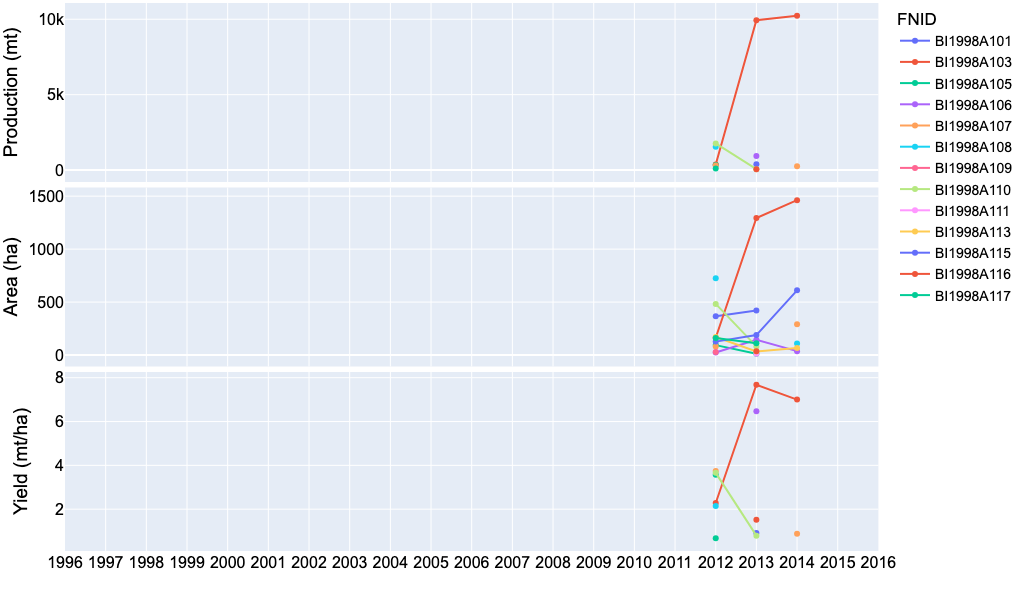

../figures/BI_line_pay_Sorghum_Season A.png is saved.


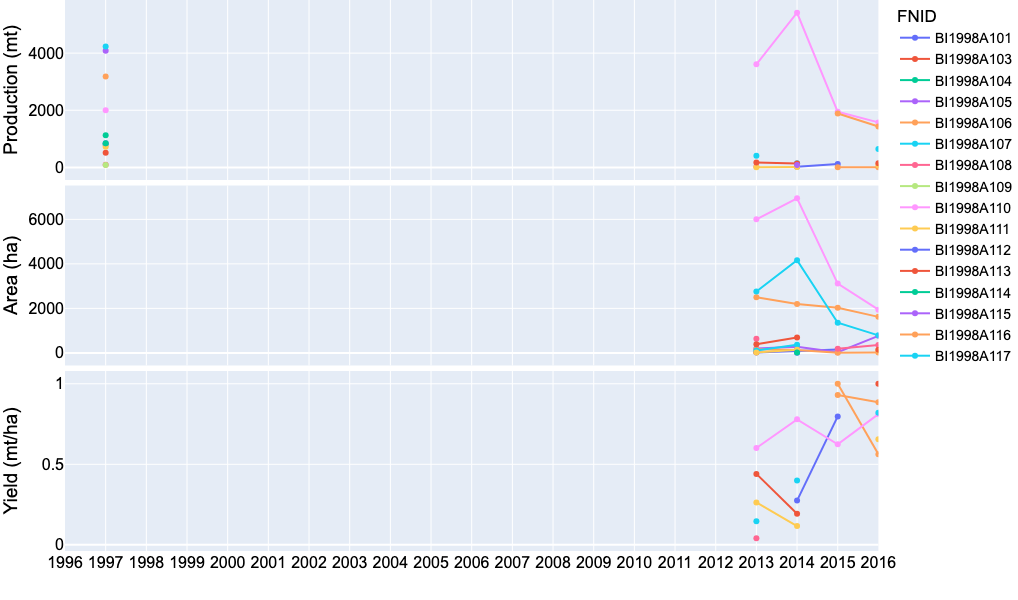

../figures/BI_line_pay_Sorghum_Season B.png is saved.


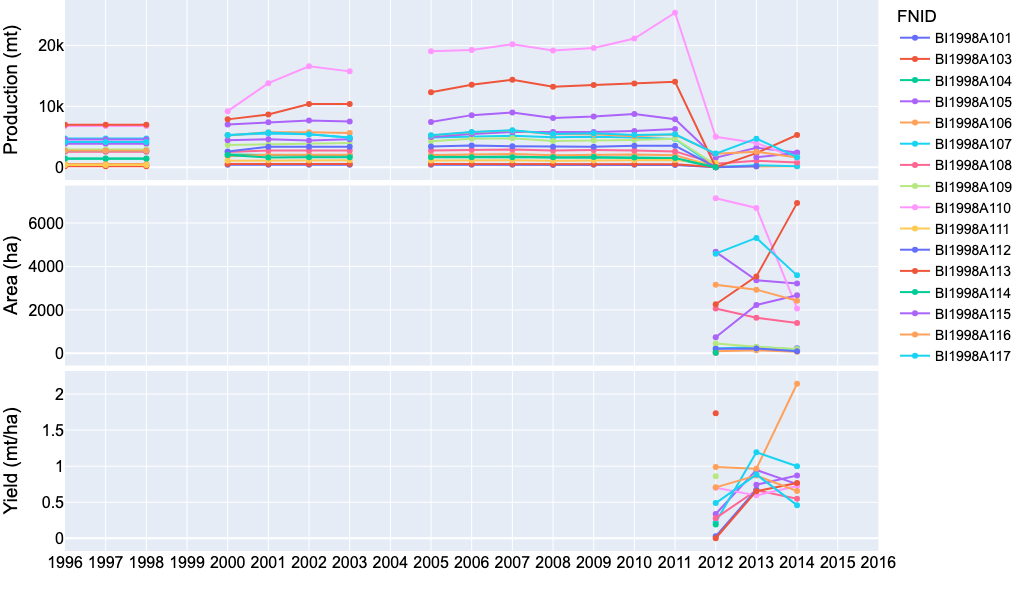

../figures/BI_line_pay_Sorghum_Season C.png is saved.


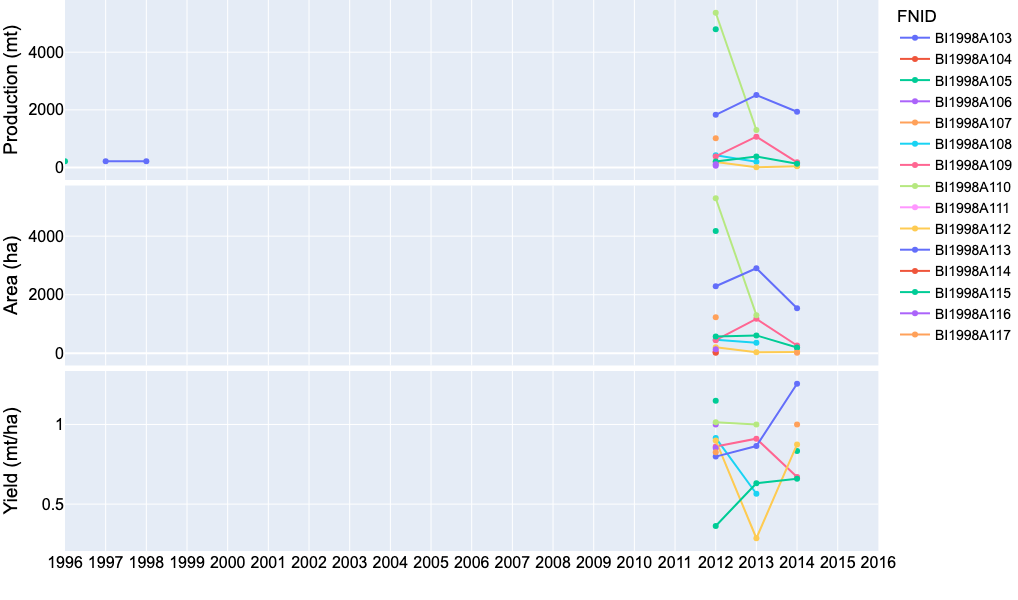

../figures/BI_line_pay_Wheat_Season A.png is saved.


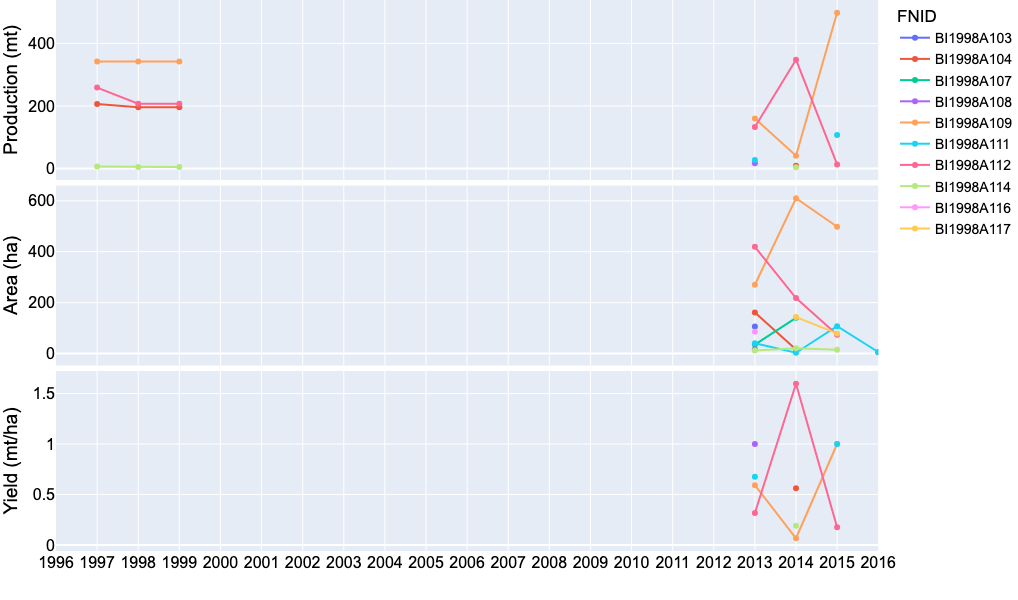

../figures/BI_line_pay_Wheat_Season B.png is saved.


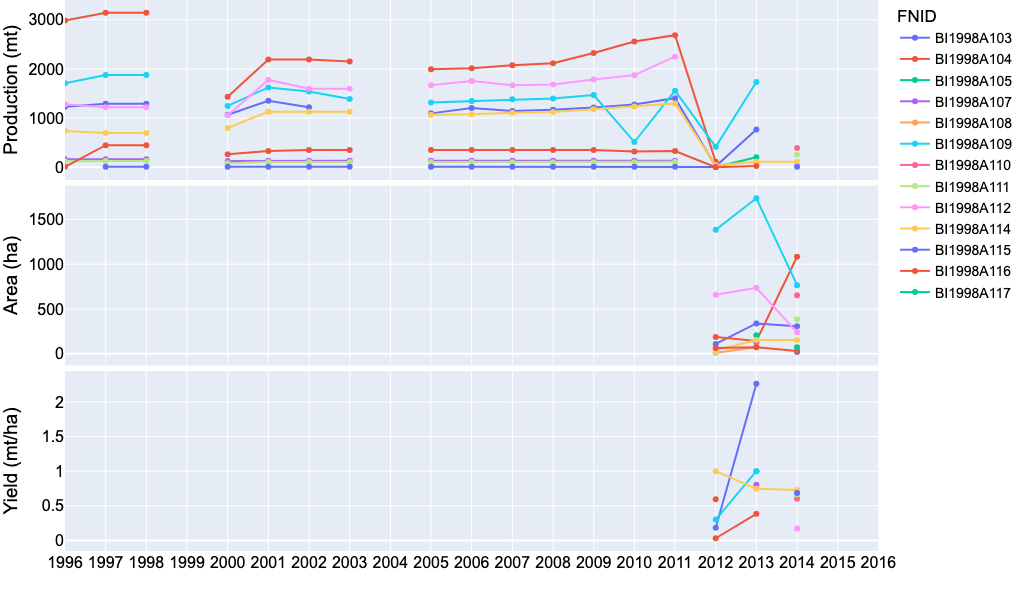

../figures/BI_line_pay_Wheat_Season C.png is saved.


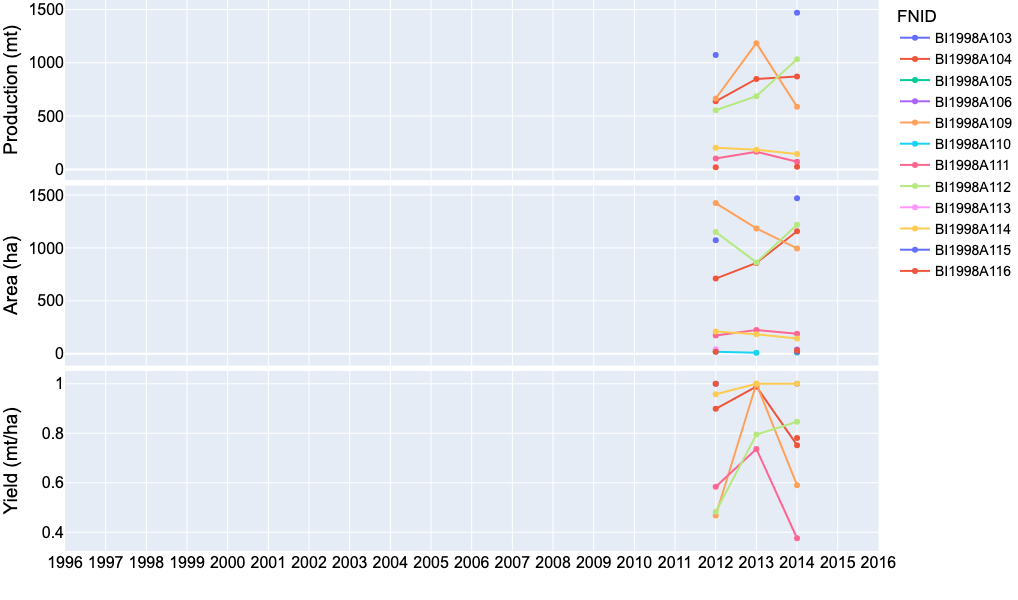

In [11]:
# Lineplot of Production-Area-Yield (PAY) time-series
country_iso, country_name = 'BI', 'Burundi'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize', 'Season A'],
    ['Maize', 'Season B'],
    ['Maize', 'Season C'],
    ['Millet', 'Season A'],
    ['Millet', 'Season B'],
    ['Millet', 'Season C'],
    ['Rice', 'Season A'],
    ['Rice', 'Season B'],
    ['Rice', 'Season C'],
    ['Rice, not husked', 'Season A'],
    ['Rice, not husked', 'Season B'],
    ['Rice, not husked', 'Season C'],
    ['Sorghum', 'Season A'],
    ['Sorghum', 'Season B'],
    ['Sorghum', 'Season C'],
    ['Wheat', 'Season A'],
    ['Wheat', 'Season B'],
    ['Wheat', 'Season C'],

]
for product_name, season_name in product_season:
    footnote = 'Production-Area-Yield (PAY) time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    if len(sub['year'].unique()) < 1:
        continue
    fig = PlotLinePAY(sub, year, footnote, fn_save)
    fig.show()


In [12]:
# Calibrated PAY time-series per FNID
from tools_graphic import PlotLineCropTS
country_iso, country_name = 'BI', 'Burundi'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; df['year'] = df['harvest_year']
link_ratio = load_npz('../data/crop/adm_crop_production_%s_ratio.npz' % country_iso)
year_all = np.arange(df['year'].min(), df['year'].max()+1)
product_season = [
    ['Maize', 'Season A'],
    ['Maize', 'Season B'],
    ['Maize', 'Season C'],
    ['Millet', 'Season A'],
    ['Millet', 'Season B'],
    ['Millet', 'Season C'],
    ['Rice', 'Season A'],
    ['Rice', 'Season B'],
    ['Rice', 'Season C'],
    ['Rice, not husked', 'Season A'],
    ['Rice, not husked', 'Season B'],
    ['Rice, not husked', 'Season C'],
    ['Sorghum', 'Season A'],
    ['Sorghum', 'Season B'],
    ['Sorghum', 'Season C'],
    ['Wheat', 'Season A'],
    ['Wheat', 'Season B'],
    ['Wheat', 'Season C'],
]
for product_name, season_name in product_season:
    sub = df[
        (df['product'] == product_name) &
        (df['season_name'] == season_name)
    ]
    for fnid in sub['fnid'].unique():
        sub_fps = sub[sub['fnid'] == fnid]
        fn_save = '../figures/crop_calibrated/%s_%s_%s_%s.png' % (country_iso, product_name, season_name, fnid)
        fig = PlotLineCropTS(sub_fps, fnid, product_name, season_name, link_ratio, year_all, fn_save)


../figures/crop_calibrated/BI_Maize_Season A_BI1998A101.png is saved.
../figures/crop_calibrated/BI_Maize_Season A_BI1998A103.png is saved.
../figures/crop_calibrated/BI_Maize_Season A_BI1998A104.png is saved.
../figures/crop_calibrated/BI_Maize_Season A_BI1998A105.png is saved.
../figures/crop_calibrated/BI_Maize_Season A_BI1998A106.png is saved.
../figures/crop_calibrated/BI_Maize_Season A_BI1998A107.png is saved.
../figures/crop_calibrated/BI_Maize_Season A_BI1998A108.png is saved.
../figures/crop_calibrated/BI_Maize_Season A_BI1998A109.png is saved.
../figures/crop_calibrated/BI_Maize_Season A_BI1998A110.png is saved.
../figures/crop_calibrated/BI_Maize_Season A_BI1998A111.png is saved.
../figures/crop_calibrated/BI_Maize_Season A_BI1998A112.png is saved.
../figures/crop_calibrated/BI_Maize_Season A_BI1998A113.png is saved.
../figures/crop_calibrated/BI_Maize_Season A_BI1998A114.png is saved.
../figures/crop_calibrated/BI_Maize_Season A_BI1998A115.png is saved.
../figures/crop_cali